# Path Planning In the Environments with Dynamic Obstacles

In this lab we consider the problem of finding a (shortest) path in the environments with dynamic obstacles. The environment is represented by a grid composed of the free and blocked cells. The trajectories of dynamic obstacles are known and represented as a sequence of occupied cells in each time moment.

For simplicity it's assumed that the agent and dynamic obstacles can perform cardinal-only moves. They can also perform a wait action. All the actions have equal duration, so it's possible to discretize the timeline saying that at each time step the agent and dynamic obstacles can either move to one of the cardinal-adjacent cells or to stay in the same cell performing a wait-action.

The search-space state is described by tuple `(i, j, t)` where `i` and `j` are the cell's coordinates, `t` - time moment. So now theoretically there are an inifinite number of states corresponding to the same grid cell.

Your task is to implement A* algorithm with timesteps that avoids dynamic obstacles with known trajectories. 

In [ ]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
from heapq import heappop, heappush, heapify
from random import randint
import time
from IPython.display import HTML
from PIL import Image, ImageDraw, ImageOps
from IPython.display import Image as Img
from IPython.display import display
from sys import float_info
from google.colab import output
from random import shuffle

EPS = float_info.epsilon
%matplotlib notebook

In [ ]:
!pip install pogema
!pip uninstall numba -y

In [ ]:
import gym
import numpy as np
from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
from pogema import GridConfig
from IPython.display import SVG, display

import gym
import pogema

## Реализация алгоритмов

### Grid Map Representation

In [ ]:
class Map_pogema: #CHANGE
    '''
    Square grid map class represents the environment for our moving agent
        - width -- the number of columns in the grid
        - height -- the number of rows in the grid
        - cells -- the binary matrix, that represents the grid. 0 - cell is traversable, 1 - cell is blocked
    '''

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def set_map(self, map, obs_rad=None):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid

        Parameters
        ----------
        cell_str : str
            String which contains map data
        width : int
            Number of grid columns
        height : int
            Number of grid rows
        '''

        
        if obs_rad:
            self._cells = map[obs_rad:-obs_rad, obs_rad:-obs_rad]
        else:
            self._cells = map
        self._width = self._cells.shape[1]
        self._height = self._cells.shape[0]
        
    

    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.

        Parameters
        ----------
        i : int
            The number of the column in which the cell is located
        j : int
            The number of the row in which the cell is located

        Returns
        -------
        bool
            Is the cell inside map bounds
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    
    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.

        Parameters
        ----------
        i : int
            The number of the column in which the cell is located
        j : int
            The number of the row in which the cell is located

        Returns
        -------
        bool
            Is the cell traversable (true) or obstacle (false)
        '''

        return not self._cells[i][j]


    def get_neighbors(self, i, j):
        '''
        Returns a list of neighbouring cells as (i, j) tuples. 
        Fucntions should returns such neighbours, that allows only cardinal moves, 
        but dissalows cutting corners and squezzing. 

        Parameters
        ----------
        i : int
            The number of the column in which the cell is located
        j : int
            The number of the row in which the cell is located

        Returns
        -------
        neighbours : list[tuple[int, int]]
            List of neighbours grid map (i, j) coordinates
        '''

        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]

        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
                
        return neighbors

    def get_size(self):
        '''
        Returns the size of the map in cells

        Returns
        -------
        tuple[int, int]
            Size of the map in cells (height, width)
        '''
        return (self._height, self._width)
        
    def get_cells(self):
        return self._cells

### Search Node Representation



In [ ]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node (also equals time moment when the agent reaches the cell)
    - h: h-value of the node // always 0 for Dijkstra
    - f: f-value of the node // always equal to g-value for Dijkstra
    - parent: pointer to the parent-node 

    '''
    

    def __init__(self, i, j, g = 0, h = 0, f = None, parent = None):
        self.i = i
        self.j = j
        self.g = g # t
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent

        
    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''
        
        return (self.i == other.i) and (self.j == other.j) and (self.g == other.g)
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        
        h = self.i, self.j, self.g
        return hash(h)


    def __lt__(self, other): 
        '''
        Comparison between self and other. Returns is self < other (self has higher priority).
        '''
        
        return self.f < other.f

### Implementing the search tree (i.e. OPEN,  CLOSED)

Efficient implementation of the search tree (OPEN and CLOSED) is crucial for any search algorithm. You should use your efficient implementation of the search tree that you've created in the previous labs). 

 

In [ ]:
class SearchTree: #SearchTree which uses PriorityQueue for OPEN and set for CLOSED
    def __init__(self):
        self._open = []           
        self._dict_open = dict()
        self._closed = set()      
        self._enc_open_dublicates = 0
        
    def __len__(self):
        return len(self._open) + len(self._closed)
                    
    def open_is_empty(self):
        return len(self._open) == 0

    
    def add_to_open(self, item):
        heappush(self._open, item)  

    def get_best_node_from_open(self):
        best_node = heappop(self._open)
        while self.was_expanded(best_node):
            if self.open_is_empty():
                return None
            best_node = heappop(self._open)
            self._enc_open_dublicates += 1
        return best_node

    def add_to_closed(self, item):
        self._closed.add(item)

    def was_expanded(self, item):
        return item in self._closed

    @property
    def OPEN(self):
        return self._open
    
    @property
    def CLOSED(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

### A* with Timesteps and with save intervals


In [ ]:
def manhattan_distance(i1, j1, i2, j2):
    '''
    Returns a manhattan distance between two cells

    Parameters
    ----------
    i1, j1 : int, int
        Position of first cell on the grid map
    i2, j2 : int, int
        Position of second cell on the grid map

    Returns
    -------
    int
        Manhattan distance between two cells

    '''
    return abs(i1 - i2) + abs(j1 - j2)

In [ ]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of simple moves

    Parameters
    ----------
    i1, j1 : int, int
        Position of first cell on the grid map
    i2, j2 : int, int
        Position of second cell on the grid map

    Returns
    -------
    int
        Cost of the move between two neighbouring cells

    '''

    d = abs(i1 - i2) + abs(j1 - j2)
    if d == 0:  # wait
        return 1
    elif d == 1:  # cardinal move
        return 1
    else:
        raise Exception('Trying to compute the cost of non-supported move!')

In [ ]:
class CATable:
    '''
    Class, which implements collision avoidance table for effective checking collisions with dynamic obstacles
    '''
    def __init__(self, dyn_obst_traj):
        '''
        TODO
        '''
        
        self.pos_time_table = dict()
        self.max_time_table = dict()
        self.collision_intervals = dict()
        
        occ_points = set()
        for obst_id, obstacle in enumerate(dyn_obst_traj):
            for t, (i, j) in enumerate(obstacle):
                self.pos_time_table[(i, j, t)] = obst_id
                occ_points.add((i,j))
            
            self.max_time_table[obstacle[-1]] = len(obstacle) - 1

        for point in occ_points:
            self.collision_intervals[point] = self.get_state_save_intervals(point[0], point[1], dyn_obst_traj)

    def get_state_save_intervals(self, x, y, dyn_obst_traj):
        t1 = 0
        t2 = -1
        collisions_time = []
        for traj in enumerate(dyn_obst_traj):
            for obstacle in dyn_obst_traj:
                for t, (i, j) in enumerate(obstacle):
                    if (i,j) == (x,y):
                       collisions_time.append(t)
        
        collision_intervals = set([(t-1, t+1) for t in collisions_time])

        return collision_intervals
    
    def save_interval(self, i, j, t):
        r = dict()
        # return True
        if not ((i, j) in self.collision_intervals):
            return True

        for interval in self.collision_intervals[(i,j)]:
            if t >= interval[0] and t <= interval[1]:
                return False
        
        return True

    def __check_pos_at_time(self, i, j, t):
        '''
        Checks, that cell (i, j) is occupied at moment t
        
        Parameters
        ----------
        i, j: int, int
            Position of cell on the grid map
        t : int
             Time moment to check
            
        Returns
        -------
        bool
            False, if cell is occupied at time moment t
            True, if not occupied at time moment t
        '''
        
        flag = (i, j, t) in self.pos_time_table
        flag = flag or (((i, j) in self.max_time_table) and (t > self.max_time_table[(i, j)]))
        
        return not flag
                
    def __check_rev_move(self, i1, j1, i2, j2, t_start):
        '''
        Checks, that the given move does not result in edge collision
        
        Parameters
        ----------
        i1, j1 : int, int
            Start cell of the move
        i2, j2 : int, int
            Target cell of the move
        t_start : int
             Time when the move starts
            
        Returns
        -------
        bool        
            True if the given move does not result in the edge collision
            False if the given move does results in the edge collision
        '''
        dt = compute_cost(i1, j1, i2, j2)
        flag1 = (i1, j1, t_start+dt) in self.pos_time_table
        flag2 = (i2, j2, t_start) in self.pos_time_table
        flag = flag1 and flag2 and self.pos_time_table[(i1, j1, t_start+dt)]==self.pos_time_table[(i2, j2, t_start)] #???
        return not flag

    def check_move(self, i1, j1, i2, j2, t_start):
        '''
        Checks if the move between (i1, j1) and (i2, j2) 
        at moment (t_start -> t_start+1) leads 
        to the collision with a dynamic obstacle.

        Parameters
        ----------
        i1, j1 : int, int
            Start cell of the move
        i2, j2 : int, int
            Target cell of the move
        t_start : int
             Time step when the move starts
            
        Returns
        -------
        bool
            Is the move valid (true) or will it lead to a collision (false)
        '''
        dt = compute_cost(i1, j1, i2, j2)
        return self.__check_pos_at_time(i2, j2, t_start+dt) and self.__check_rev_move(i1, j1, i2, j2, t_start)

In [ ]:
def get_neighbors_wrt_time(i, j, t, grid_map, ca_table, with_save_intevals = True):
    '''
    Returns a list of neighbouring cells as (i, j) tuples. 
    
    Should return such neighbours, that result
    from non-colliding actions (cardinal moves and wait) w.r.t.
    the given time step.
    
    I.e. the succesor cell should be free at the next time step,
    as well at the move should not result in the edge collision.
    
    Parameters
    ----------
    i, j : int
        Cell coordinates
    grid_map : Map
        An additional domain information (such as grid map).
    ca_table : CATable
        Collision avoidance table

    Returns
    -------
    neighbours : list[tuple[int, int]]
        List of neighbours grid map (i, j) coordinates
    '''

    neighbors = grid_map.get_neighbors(i, j)
    neighbors.append((i, j))
    result = []
#     print(f'neighbors: {neighbors}')

    for neighbor in neighbors:
#         print(f'neighbor: {neighbor}')
        if ca_table.check_move(i, j, *neighbor, t):
            if with_save_intevals:
                if ca_table.save_interval(i, j, t):
                    result.append(neighbor)
            else:
                result.append(neighbor)

    return result

In [ ]:
def astar_timesteps(grid_map, ca_table, start_i, start_j, goal_i, goal_j, heuristic_func = None, search_tree = None,
                    with_save_intevals = True, max_iter = 1000):
    '''
    Runs A* search algorithm without re-expansion on dynamic obstacles domain.

    Parameters
    ----------
    grid_map : Map
        An additional domain information (such as grid map).
    ca_table : CATable
        Collision avoidance table
    start_i, start_j : int, int
        Start cell
    goal_i, goal_j  : int, int
        Goal cell
    heuristic_func : function
        Heuristic function
    search_tree : type 
        Search tree data structure

    Returns
    -------
    path_found : bool
        Path was found or not.  
    last_node : Node
        The last node in path. None if path was not found.
    steps : int
        The number of search steps
    noodes_created : int
        The number of nodes, which were created and stored during the search process (size of the resultant search tree)
    open : iterable object
        Iterable collection of OPEN nodes
    expanded : iterable object
        Iterable collection of the expanded nodes
    '''

    ast = search_tree()
    steps = 0
    nodes_created = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    
    #CODE HERE
    CLOSED = None
    path_found = False
    last_Node = None
    OPEN = None #MODIFY THIS
    
    ast.add_to_open(start_node)
    iter = 0
    while not ast.open_is_empty():
        sc = ast.get_best_node_from_open()
        if sc is None:
            break
        if iter > max_iter:
            path_found = False
            break

        if (sc.i, sc.j) == (goal_i, goal_j):
            path_found = True
            last_Node = sc
            break
        succ_cord = get_neighbors_wrt_time(sc.i, sc.j, sc.g, grid_map, ca_table, with_save_intevals)
#         grid_map.get_neighbors(sc.i, sc.j)
        steps += 1
        for coord in succ_cord:
            h = heuristic_func(*coord, goal_i, goal_j)
            new_node = Node(*coord, g=sc.g+compute_cost(sc.i, sc.j, *coord), h=h, parent=sc)
            if ast.was_expanded(new_node):
                continue
            ast.add_to_open(new_node)
        last_Node = sc
        ast.add_to_closed(sc)
        iter += 1
        
    
    nodes_created = len(ast)
    
    OPEN = ast.OPEN
    CLOSED = ast.CLOSED

    return path_found, last_Node, steps, nodes_created, OPEN, CLOSED

### Доп. функции

In [ ]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [ ]:
def make_list(path):
    list_path = []
    for node in path:
        list_path.append((node.i, node.j))
    return list_path

def valid_movement_check(indx, iter, path, avail_movements):
    path_agent = path[indx]
    if iter+1 >= len(path_agent):
        return 0
    movement = (path_agent[iter+1][0] - path_agent[iter][0], path_agent[iter+1][1] - path_agent[iter][1])
    if movement in avail_movements:
        return avail_movements.index(movement)
    # print('! --', movement)
    return 0

### Visualization

In [ ]:
def draw(env, dyn_obst_traj, paths, output_filename = 'render', egocentric_idx=None):
    movement = [(0, 0), (-1, 0), (1, 0), (0, -1), (0, 1)]
    done = [False, ...]
    trs = dyn_obst_traj.copy()

    for path in paths:
        trs.append(make_list(path)) 
    max_iter = np.array([len(path) for path in paths]).max()
    iter = 0
    for iter in range(max_iter):
        obs, reward, done, info = env.step([valid_movement_check(indx, iter, trs, movement) for indx in range(env.grid_cfg.num_agents)])
        # env.render()


    env.save_animation(output_filename+".svg", egocentric_idx=egocentric_idx)
    display(SVG(output_filename+".svg"))

# Эксперименты

## Динамические препятствия!

### Код теста

In [ ]:
def set_start_end(s, e, obs):
    start = []
    end = []
    for tr in obs:
        start.append(tr[0])
        end.append(tr[-1])
    if len(s)!=len(e):
        raise Exception("start and end points")
    for i in range(len(s)):
        start.append(s[i])
        end.append(e[i])
    return start, end, len(start)

In [ ]:
def simple_test_pogema(search_func, task, *args):
    '''
    simple_test runs search_func on one task (use a number from 0 to 4 to 
    choose a certain debug task on simple map or None to choose a random task 
    from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     
    Parameters
    ----------
    search_func : function
        Function, which implements the method to run
    task : int
        Number of task from pregenerated set. Must be in the range from 0 to 4 (use None ro run random task)
    '''
    
    grid = grid = """
    ...##........##...#..##.......
    ...#####..#..##......##.......
    .......#..#..##...#..##.......
    ...##..#..#..##...#..##.......
    ...##..#..#..##...#..##....... 
    ...##..#..#..##...#..#####....
    ...##..#..#..##...#..#####....
    .......#..#..##...#..#........
    ...##..#..#..##...#..#........
    ...##..#..#..##...#..#........
    ...##.....#.......#...........
    ...#############.##.#######.##
    ...##........##...............
    ..............................
    ...##........##...............
    """
    starts = [(1, 28), (2, 29), (3, 20), (3, 20), (0, 0)]
    goals = [(0, 1), (6, 2), (5, 6), (13, 0), (4, 23)]
    dyn_obst_traj = []
    # dyn_obst_traj.append([(12,2), (11,2), (12,2), (13,2), (14,2), (13,2), (12,2), (11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2),(11,2), (12,2), (13,2), (14,2), (13,2), (12,2), (1, 27)])
    dyn_obst_traj.append([(13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (13,2), (13,3), (13,2), (13,1), (13, 0), (13, 1), (1, 26)])
    dyn_obst_traj.append([(1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), 
                          (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), 
                          (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), 
                          (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), 
                          (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), 
                          (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), 
                          (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), 
                          (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2,1), (1,1), (1,2), (2,2), (2, 1), (4, 1)])
    dyn_obst_traj.append([(7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), 
                          (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), 
                          (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), 
                          (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), 
                          (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), 
                          (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), 
                          (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), (7,4), (7,3), (7,2), (7,1), (7,2), (7,3), 
                          (7,4), (7,3), (7,2), (0, 29)])
    dyn_obst_traj.append([(13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (13,10), (13,11), (13,12), (13,13), (13,14), (13,15), (13,16), (13,17), (13,16), (13,15), (13,14), (13,13), (13,12), (13,11), (0, 28)])
    dyn_obst_traj.append([(11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (11,16), (12,16), (12,17), (12,18), (12,19), (11,19), (12,19), (12,18), (12,17), (12,16), (0, 27)])
    dyn_obst_traj.append([(4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (4,0), (4,1), (3,1), (3,0), (0, 26)])
    dyn_obst_traj.append([(10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (10,20), (10, 21), (10,22), (10,23), (10,24), (10,23), (10,22), (10,21), (0, 25)])
    dyn_obst_traj.append([(12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (12,6), (12,7), (13,7), (13,6), (0, 24)])
    dyn_obst_traj.append([(12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (12,26), (12,27), (11,27), (12,27), (12,28), (12,27), (0, 23)])
    
    if (task is None) or not (0 <= task < 5):
        task = randint(0, 4)
    
    start_p, end_p, num_agents = set_start_end([starts[task]], [goals[task]], dyn_obst_traj)

    grid_config = GridConfig(map=grid, num_agents=num_agents, seed=41, agents_xy=start_p, targets_xy=end_p)
    env = gym.make('Pogema-v0', config=grid_config)
    env = AnimationMonitor(env)

    obs = env.reset()

    # env.render()

    task_map = Map_pogema()
    task_map.set_map(env.grid.obstacles, grid_config.obs_radius)

    ca_table = CATable(dyn_obst_traj)
    
    lengths = [54, 47, 48, 38, 56]

    start = Node(*starts[task])
    goal = Node(*goals[task])
    true_length = lengths[task]

    result = search_func(task_map, ca_table, start.i, start.j, goal.i, goal.j, *args)
    
    number_of_steps = result[2]
    nodes_created = result[3]
    if result[0]:
        path, length = make_path(result[1])
        correct = (int(length)  == int(true_length))
        if not correct:
            print(int(length), 'but true is', int(true_length))
        print("Path found! Length: " + str(length) + \
              ". Nodes created: " + str(nodes_created) + \
              ". Number of steps: " + str(number_of_steps) + \
              ". Correct: " + str(correct))
        draw(env, dyn_obst_traj, [path], egocentric_idx=len(dyn_obst_traj))
        
    else:
        print("Path not found!")

### Сам эксперимент

In [ ]:
!pip install --upgrade pillow

     |████████████████████████████████| 4.3 MB 5.1 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
%time simple_test_pogema(astar_timesteps, 0, manhattan_distance, SearchTree)

Path not found!
CPU times: user 99.7 ms, sys: 2.15 ms, total: 102 ms
Wall time: 105 ms


## Тест для n агентов!

### Код теста

Пока работает с одним, ибо A* для одного

In [ ]:
def get_start_and_goal(env):
    d = grid_config.obs_radius
    starts = []
    goals = []
    for x, y in env.grid.positions_xy:
        starts.append((x - d, y - d))
    for x, y in env.grid.finishes_xy:
        goals.append((x - d, y - d))
    return starts, goals

In [ ]:
def planning_algorithm(env, starts, goals, search_func, task_map, max_iter, *args):
    dyn_obst_traj = []
    paths = []
    prioritizied = [i for i in range(len(starts))]
    fail = True
    iter = 0
    fail_agents = []
    while (iter < max_iter) and fail:
        iter+=1
        paths.clear()
        paths = [0 for i in range(len(starts))]
        dyn_obst_traj.clear()
        
        prioritizied = [i for i in range(len(starts)) if not (i in fail_agents)]
        shuffle(prioritizied)
        prioritizied = fail_agents + prioritizied
        fail_agents.clear()
        fail = False
        for i in prioritizied:
            ca_table = CATable(dyn_obst_traj)
            start = Node(*starts[i]) # TODO: и в search_func передавать все начальные и конечные точки
            goal = Node(*goals[i])
            result = search_func(task_map, ca_table, start.i, start.j, goal.i, goal.j, *args)
            
            number_of_steps = result[2]
            nodes_created = result[3]
            if result[0]:
                path, length = make_path(result[1])
                dyn_obst_traj.append([(n.i, n.j) for n in path])
                paths[i] = path          # TODO: для мультиагентности сделать список всех путей агентов             
            else:
                fail = True
                fail_agents.append(i)
    if iter > 1000 or not fail:
        pathsFound = True
        dyn_obst_traj.clear()
        draw(env, dyn_obst_traj, paths)
        print('Path found!')
    else:
        pathsFound = False
        print('Path not found!')
    return pathsFound, paths

М

In [ ]:
def planning_algorithm(env, starts, goals, search_func, task_map, max_iter, print_animation, *args): #add print_anim
    dyn_obst_traj = []
    paths = []
    prioritizied = [i for i in range(len(starts))]
    fail = True
    iter = 0
    fail_agents = []
    agent_info = {'ISR': [False for i in range(len(starts))]}
    while (iter < max_iter) and fail:
        iter+=1
        paths.clear()
        paths = [0 for i in range(len(starts))]
        dyn_obst_traj.clear()
        
        prioritizied = [i for i in range(len(starts)) if not (i in fail_agents)]
        shuffle(prioritizied)
        prioritizied = fail_agents + prioritizied
        fail_agents.clear()
        fail = False
        for i in prioritizied:
            ca_table = CATable(dyn_obst_traj)
            start = Node(*starts[i]) 
            goal = Node(*goals[i])
            result = search_func(task_map, ca_table, start.i, start.j, goal.i, goal.j, *args)
            
            number_of_steps = result[2]
            nodes_created = result[3]
            if result[0]:
                path, length = make_path(result[1])
                dyn_obst_traj.append([(n.i, n.j) for n in path])
                paths[i] = path                       
            else:
                fail = True
                fail_agents.append(i)
    if iter > 1000 or not fail:
        pathsFound = True
        dyn_obst_traj.clear()
        if print_animation:
            draw(env, dyn_obst_traj, paths)
            print('Path found!')
    else:
        pathsFound = False
        if print_animation:
            print('Path not found!')
    return pathsFound, paths, agent_info

In [ ]:
def one_test_with_config(search_func, grid_config, max_iter=100, *args):    
    env = gym.make('Pogema-v0', config=grid_config)
    env = AnimationMonitor(env)
    env.reset()
    starts, goals = get_start_and_goal(env)
    # env.render()

    task_map = Map_pogema()
    task_map.set_map(env.grid.obstacles, grid_config.obs_radius)
    planning_algorithm(env, starts, goals, search_func, task_map, max_iter, *args)

In [ ]:
def massive_test(search_func, grid_config, num_tests, format=-1, max_iter=100, *args):  
    makespan = []
    ISR = []
    CSR = [] 
    for iter_test in range(num_tests):
        env = gym.make('Pogema-v0', config=grid_config)
        env = AnimationMonitor(env)
        env.reset()

        starts, goals = get_start_and_goal(env)

        task_map = Map_pogema()
        task_map.set_map(env.grid.obstacles, grid_config.obs_radius)

        results = planning_algorithm(env, starts, goals, search_func, task_map, max_iter, *args)
        CSR.append(results[0])
    print('CSR --', np.array(CSR).mean())

### Код эксперимента

Один тест с анимацией

In [ ]:
grid_config = GridConfig(num_agents=9,  # number of agents
                         size=8, # size of the grid
                         density=0.3,  # obstacle density
                         seed=0,  # set to None for random 
                                  # obstacles, agents and targets 
                                  # positions at each reset
                         max_episode_steps=128,  # horizon
                         obs_radius=5,  # defines field of view
                         )

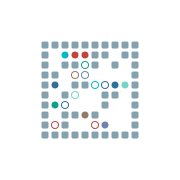

Path found!
CPU times: user 170 ms, sys: 0 ns, total: 170 ms
Wall time: 171 ms


In [ ]:
%time one_test_with_config(astar_timesteps, grid_config, manhattan_distance, SearchTree, True, max_iter = 10)

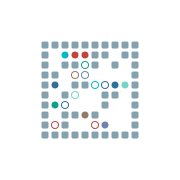

Path found!
CPU times: user 292 ms, sys: 982 µs, total: 293 ms
Wall time: 296 ms


In [ ]:
%time one_test_with_config(astar_timesteps, grid_config, manhattan_distance, SearchTree, False)

Несколько тестов с метриками (доделаю)

In [ ]:
grid_config_m = GridConfig(num_agents=30,  # number of agents
                         size=64, # size of the grid
                         density=0.3,  # obstacle density
                         max_episode_steps=128,  # horizon
                         obs_radius=5,  # defines field of view
                         )

## Тесты с безопасными интервалами

10 - количество попыток перепланирования

8000 - макс количество итераций А*

Path not found!
Path not found!


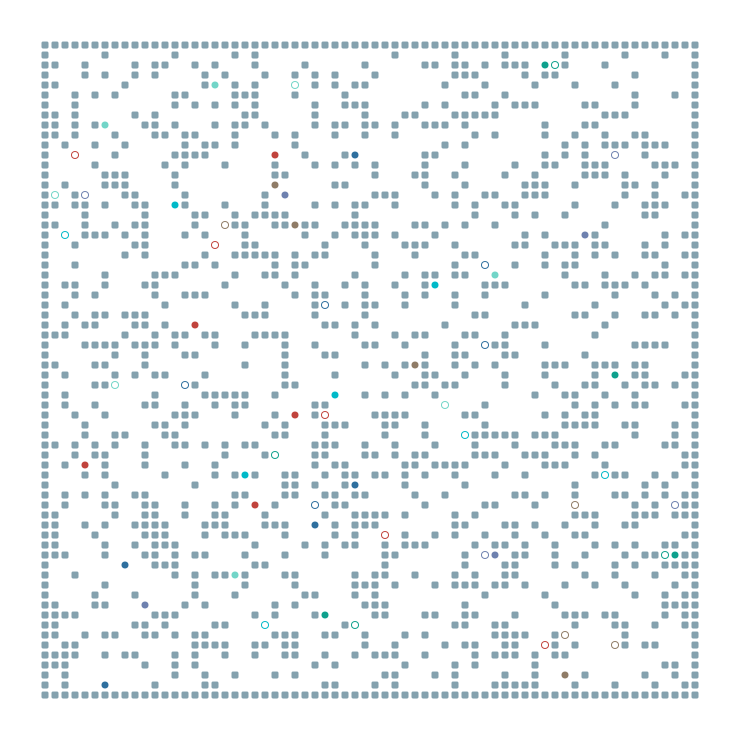

Path found!
Path not found!


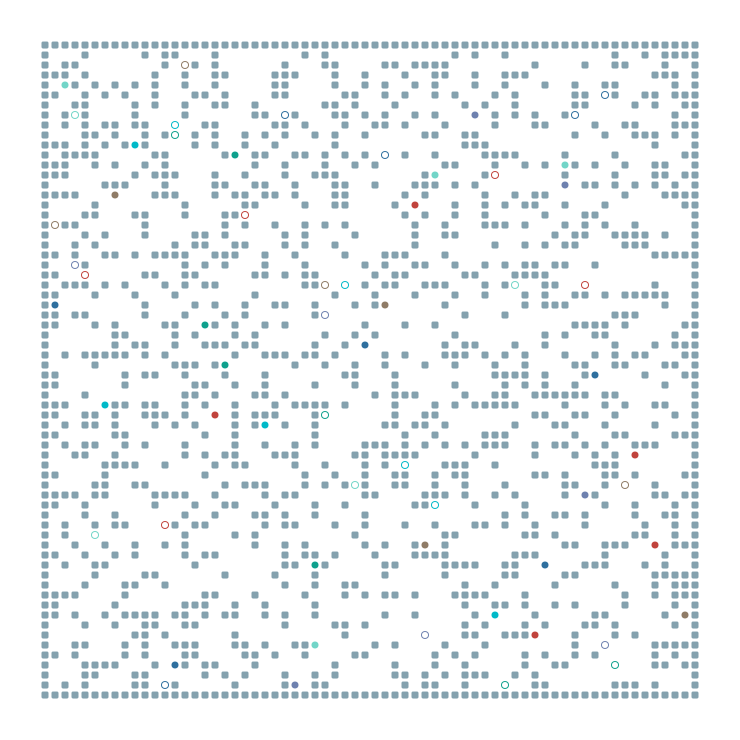

Path found!


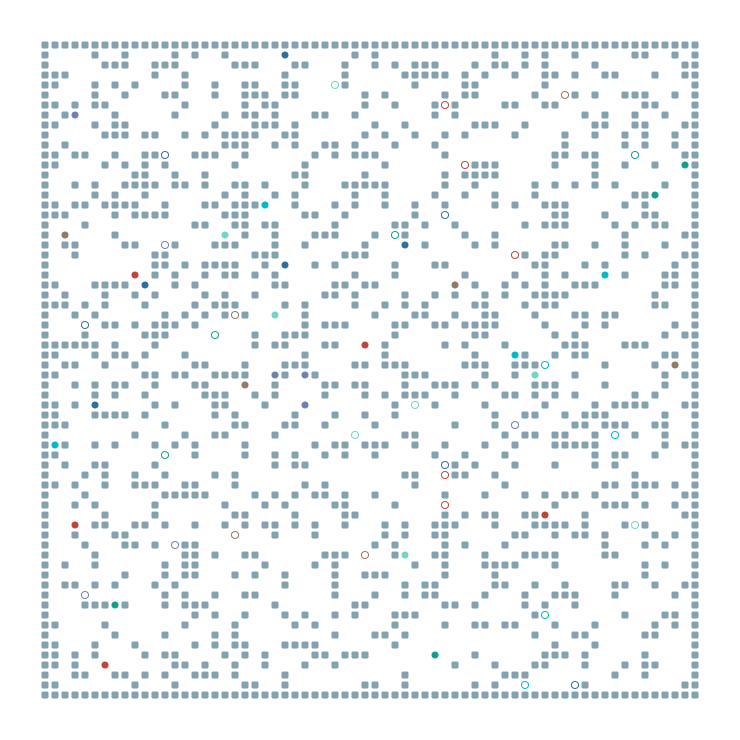

Path found!


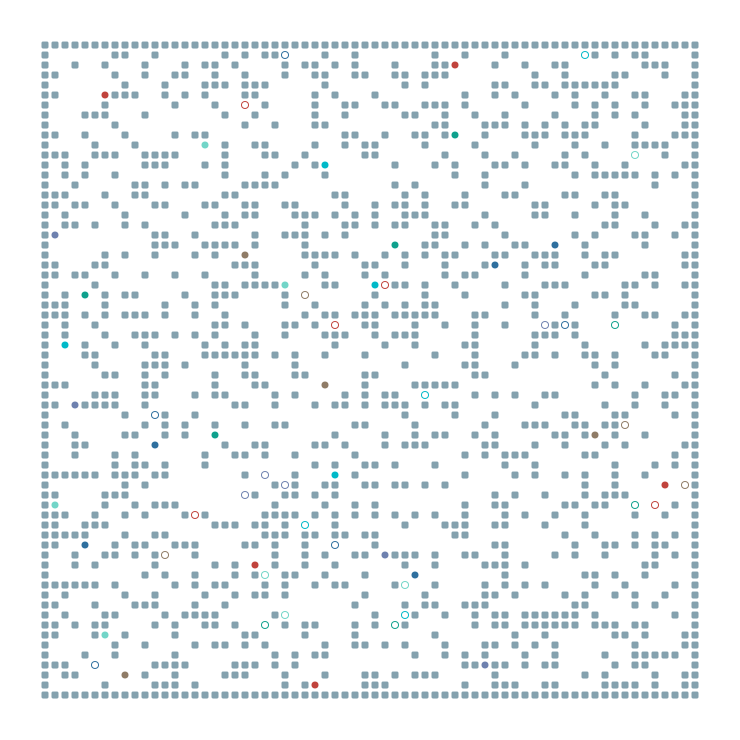

Path found!


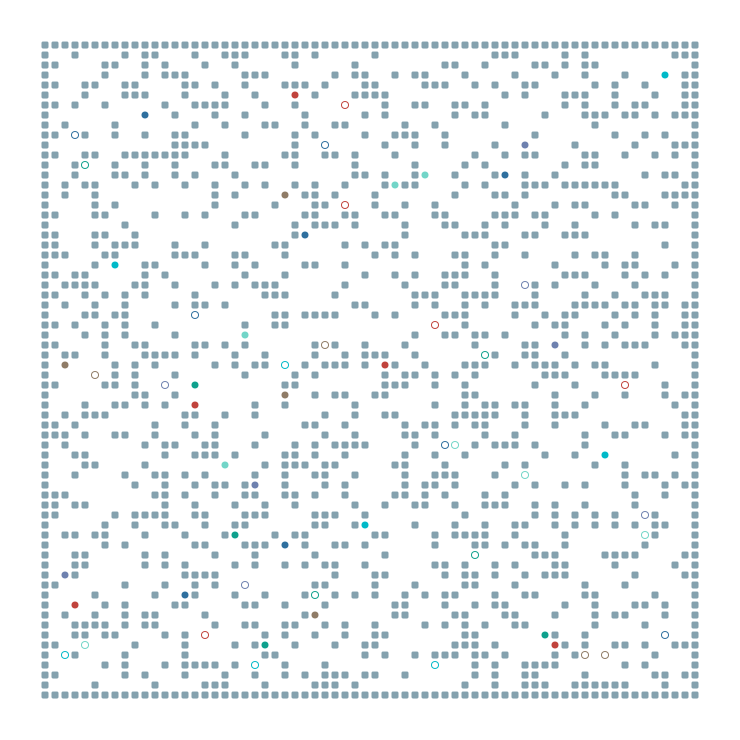

Path found!


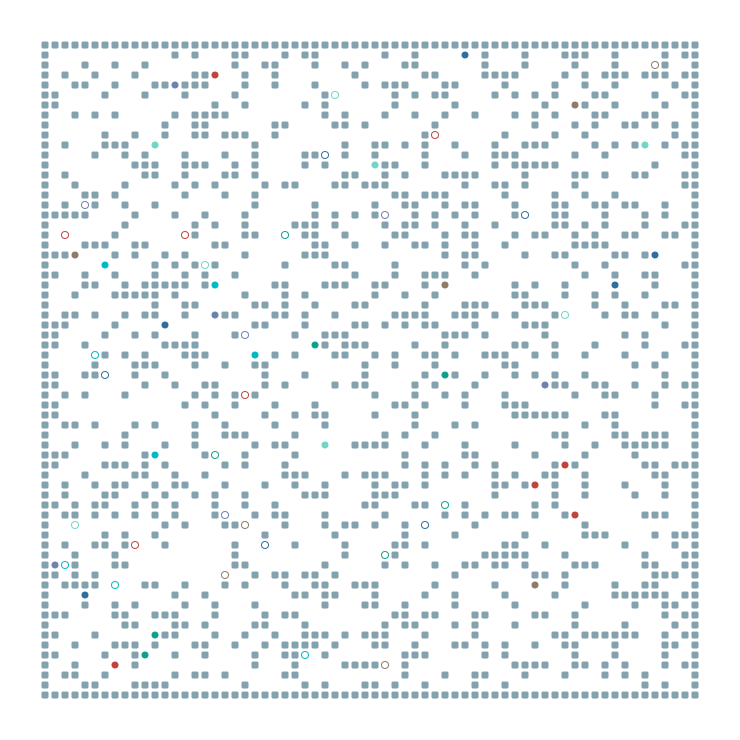

Path found!
Path not found!
CSR -- 0.6
CPU times: user 33min 42s, sys: 4.18 s, total: 33min 46s
Wall time: 33min 50s


In [ ]:
%time massive_test(astar_timesteps, grid_config_m, 10, -1, 10, manhattan_distance, SearchTree, True, 8000)

## Тесты без безопасных интервалов

Path not found!
Path not found!


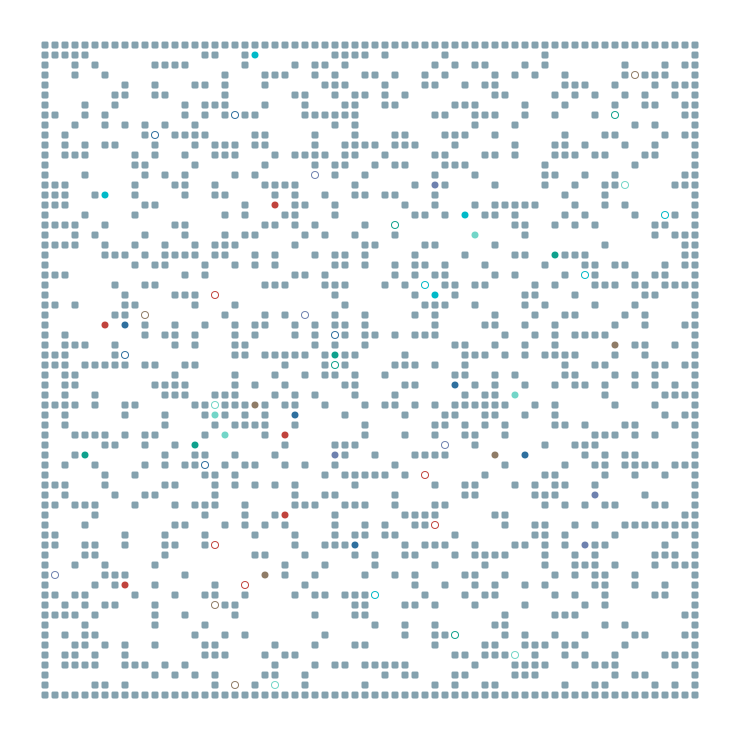

Path found!
Path not found!
Path not found!


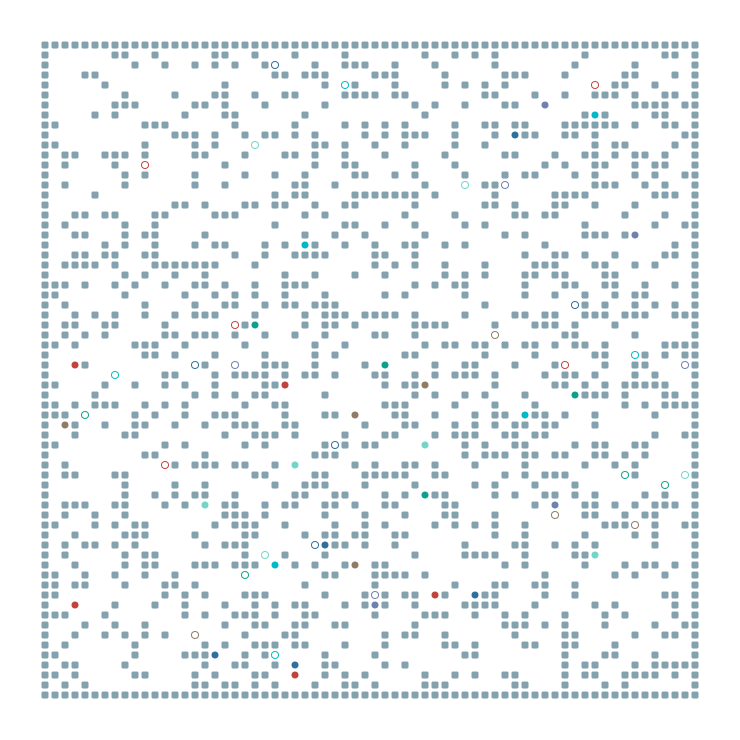

Path found!
Path not found!
Path not found!


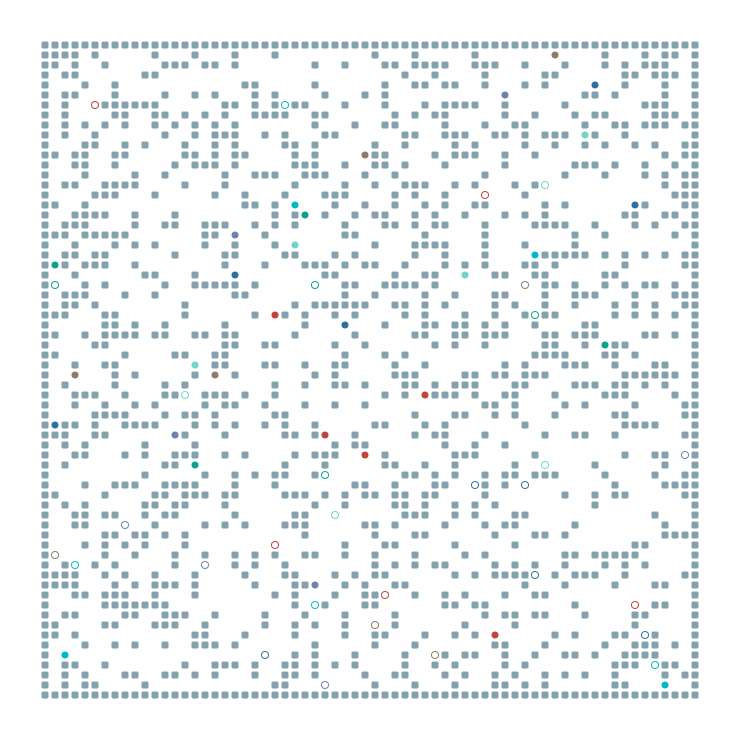

Path found!


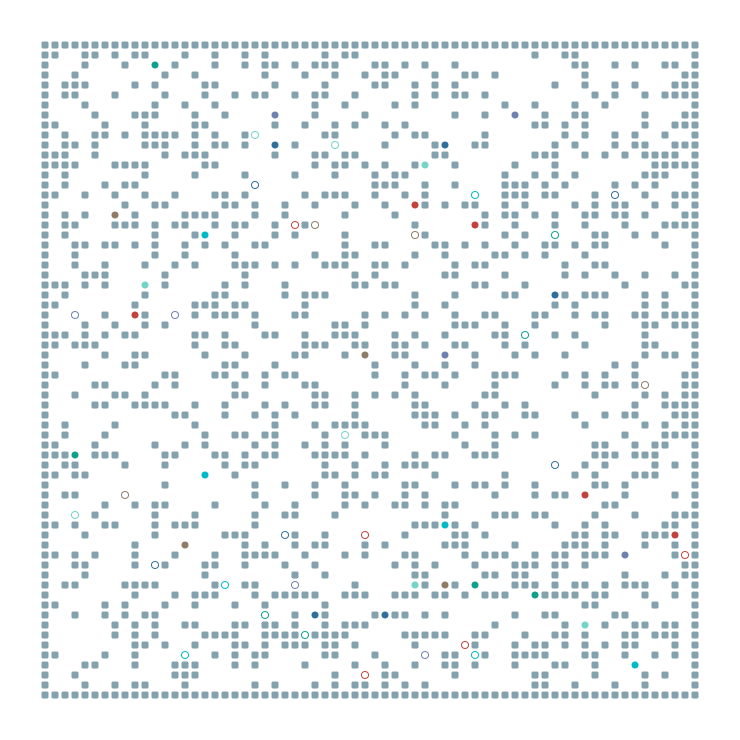

Path found!
CSR -- 0.4
CPU times: user 43min 44s, sys: 5.46 s, total: 43min 49s
Wall time: 43min 55s


In [ ]:
%time massive_test(astar_timesteps, grid_config_m, 10, -1, 10, manhattan_distance, SearchTree, False, 8000)

Определенные карты (доделаю)

In [ ]:
grid = """
######.######
######.######
######.######
######.######
######.######
######.######
.............
######.######
######.######
######.######
######.######
######.######
######.######
"""
grid_config = GridConfig(map=grid, num_agents=3, seed=41)